In [0]:
!nvidia-smi

Tue May  5 05:07:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
#! -*- coding:utf-8 -*-
import re, os, json, codecs, gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight as cw

from keras import Sequential

from keras.models import Model

from keras.layers import LSTM,Activation,Dense,Dropout,Input,Embedding,BatchNormalization,Add,concatenate,Flatten
from keras.layers import Conv1D,Conv2D,Convolution1D,MaxPool1D,SeparableConv1D,SpatialDropout1D,GlobalAvgPool1D,GlobalMaxPool1D,GlobalMaxPooling1D
from keras.layers.pooling import _GlobalPooling1D
from keras.layers import MaxPooling2D,GlobalMaxPooling2D,GlobalAveragePooling2D

from keras.optimizers import RMSprop,Adam

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

from keras.utils import to_categorical

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


### 读取文件

In [0]:
train_dataset_path = "train.txt"
test_dataset_path = "test.txt"
label_dataset_path = "class.txt"

train_df = pd.read_csv(train_dataset_path,encoding="utf-8",sep='\t',names=["text","label"])
test_df = pd.read_csv(test_dataset_path,encoding="utf-8",sep = '\t',names=["text","label"])
label_df = pd.read_csv(label_dataset_path,encoding="utf-8",header=None,sep = '\t')

In [0]:
train_df

,text,label
0,中华女子学院：本科层次仅1专业招男生,3
1,两天价网站背后重重迷雾：做个网站究竟要多少钱,4
2,东5环海棠公社230-290平2居准现房98折优惠,1
3,卡佩罗：告诉你德国脚生猛的原因 不希望英德战踢点球,7
4,82岁老太为学生做饭扫地44年获授港大荣誉院士,5
...,...,...
179995,侧滑掌上PSP手机 索爱Xperia Play评测,4
179996,皖通高速跌0.8% 国元香港给予买入评级,2
179997,《无限江湖》近日更新,8
179998,廊坊十九城邦别墅现内部认购96折均价7000(图),1


In [0]:
test_df

,text,label
0,词汇阅读是关键 08年考研暑期英语复习全指南,3
1,中国人民公安大学2012年硕士研究生目录及书目,3
2,日本地震：金吉列关注在日学子系列报道,3
3,名师辅导：2012考研英语虚拟语气三种用法,3
4,自考经验谈：自考生毕业论文选题技巧,3
...,...,...
9995,萨博称已接近达成并购协议,2
9996,香港建屋贷款进军内地节能行业,2
9997,卓尔控股收购香港上市港口公司,2
9998,中国建筑拟5供1供股筹35.8亿元 每股供6元,2


In [0]:
label_df

,0
0,finance
1,realty
2,stocks
3,education
4,science
5,society
6,politics
7,sports
8,game
9,entertainment


### 去除无标签的数据

In [0]:
train_df.dropna(axis=0, how='any', inplace=True)

In [0]:
train_df

,text,label
0,中华女子学院：本科层次仅1专业招男生,3
1,两天价网站背后重重迷雾：做个网站究竟要多少钱,4
2,东5环海棠公社230-290平2居准现房98折优惠,1
3,卡佩罗：告诉你德国脚生猛的原因 不希望英德战踢点球,7
4,82岁老太为学生做饭扫地44年获授港大荣誉院士,5
...,...,...
179995,侧滑掌上PSP手机 索爱Xperia Play评测,4
179996,皖通高速跌0.8% 国元香港给予买入评级,2
179997,《无限江湖》近日更新,8
179998,廊坊十九城邦别墅现内部认购96折均价7000(图),1


### 清除文本数据

In [0]:
import re
def filter(text):
    text = re.sub("[A-Za-z0-9\!\=\？\%\[\]\,\（\）\>\<:&lt;\/#\. -----\_]", "", text)
    text = text.replace('图片', '')
    text = text.replace('\xa0', '') # 删除nbsp
    # new
    r1 =  "\\【.*?】+|\\《.*?》+|\\#.*?#+|[.!/_,$&%^*()<>+""'?@|:~{}#]+|[——！\\\，。=？、：“”‘’￥……（）《》【】]"
    cleanr = re.compile('<.*?>')
    text = re.sub(cleanr, ' ', text)        #去除html标签
    text = re.sub(r1,'',text)
    text = text.strip()
    return text


In [0]:
def clean_text(data):
    data['text'] = data['text'].apply(lambda x: filter(x))
    return data

train = clean_text(train_df)
test = clean_text(test_df)

In [0]:
train

,text,label
0,中华女子学院本科层次仅专业招男生,3
1,两天价网站背后重重迷雾做个网站究竟要多少钱,4
2,东环海棠公社平居准现房折优惠,1
3,卡佩罗告诉你德国脚生猛的原因不希望英德战踢点球,7
4,岁老太为学生做饭扫地年获授港大荣誉院士,5
...,...,...
179995,侧滑掌上手机索爱评测,4
179996,皖通高速跌国元香港给予买入评级,2
179997,近日更新,8
179998,廊坊十九城邦别墅现内部认购折均价图,1


In [0]:
test

,text,label
0,词汇阅读是关键年考研暑期英语复习全指南,3
1,中国人民公安大学年硕士研究生目录及书目,3
2,日本地震金吉列关注在日学子系列报道,3
3,名师辅导考研英语虚拟语气三种用法,3
4,自考经验谈自考生毕业论文选题技巧,3
...,...,...
9995,萨博称已接近达成并购协议,2
9996,香港建屋贷款进军内地节能行业,2
9997,卓尔控股收购香港上市港口公司,2
9998,中国建筑拟供供股筹亿元每股供元,2


### 标签统计

Text(0.5, 1.0, 'News sentiment analysis')

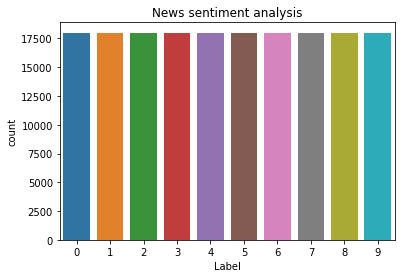

In [0]:
sns.countplot(train_df["label"])
plt.xlabel("Label")
plt.title("News sentiment analysis")

Text(0.5, 1.0, 'News sentiment analysis')

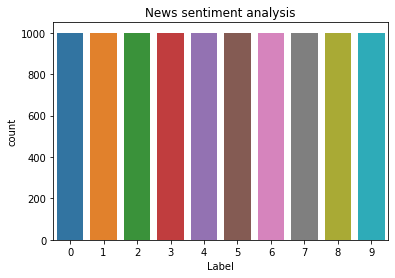

In [0]:
sns.countplot(test_df["label"])
plt.xlabel("Label")
plt.title("News sentiment analysis")

### 最终数据集

In [0]:
train_df["ocr"] = train_df["text"]
test_df["ocr"] = test_df["text"]


In [0]:
train_df = train_df[:25000]

In [0]:
train_df.shape

(25000, 3)

In [0]:
train_df

,text,label,ocr
0,中华女子学院本科层次仅专业招男生,3,中华女子学院本科层次仅专业招男生
1,两天价网站背后重重迷雾做个网站究竟要多少钱,4,两天价网站背后重重迷雾做个网站究竟要多少钱
2,东环海棠公社平居准现房折优惠,1,东环海棠公社平居准现房折优惠
3,卡佩罗告诉你德国脚生猛的原因不希望英德战踢点球,7,卡佩罗告诉你德国脚生猛的原因不希望英德战踢点球
4,岁老太为学生做饭扫地年获授港大荣誉院士,5,岁老太为学生做饭扫地年获授港大荣誉院士
...,...,...,...
24995,残疾人刑满释放无人接收警方助其敬老院安家,5,残疾人刑满释放无人接收警方助其敬老院安家
24996,国际氛围好股开门红,2,国际氛围好股开门红
24997,华商基金启动闯关大行动,0,华商基金启动闯关大行动
24998,八道湾胡同拆迁鲁迅故居将保留,1,八道湾胡同拆迁鲁迅故居将保留


In [0]:
test_df = test_df[:5000]

In [0]:
test_df

,text,label,ocr
0,词汇阅读是关键年考研暑期英语复习全指南,3,词汇阅读是关键年考研暑期英语复习全指南
1,中国人民公安大学年硕士研究生目录及书目,3,中国人民公安大学年硕士研究生目录及书目
2,日本地震金吉列关注在日学子系列报道,3,日本地震金吉列关注在日学子系列报道
3,名师辅导考研英语虚拟语气三种用法,3,名师辅导考研英语虚拟语气三种用法
4,自考经验谈自考生毕业论文选题技巧,3,自考经验谈自考生毕业论文选题技巧
...,...,...,...
4995,鸠山由纪夫发表大选胜利宣言,6,鸠山由纪夫发表大选胜利宣言
4996,希腊爆发全国性罢工活动国家电视台不再播新闻,6,希腊爆发全国性罢工活动国家电视台不再播新闻
4997,韩国媒体担忧朝方利用上游大坝水攻,6,韩国媒体担忧朝方利用上游大坝水攻
4998,德国大多数政党要求美从德撤出核武器,6,德国大多数政党要求美从德撤出核武器


### 安装bert

In [0]:
!pip install keras_bert

  Created wheel for keras-bert: filename=keras_bert-0.81.0-cp36-none-any.whl size=37913 sha256=d827de00fd3eeace058cd5ff589e1da4a82b09d87a3257c19147d814a22d38b9
  Stored in directory: /root/.cache/pip/wheels/bd/27/da/ffc2d573aa48b87440ec4f98bc7c992e3a2d899edb2d22ef9e
  Created wheel for keras-transformer: filename=keras_transformer-0.33.0-cp36-none-any.whl size=13260 sha256=02e42cebce6aa358bf65c8c96abcdda09bdda8dfc2f9ee5a5ebd9f49358675e2
  Stored in directory: /root/.cache/pip/wheels/26/98/13/a28402939e1d48edd8704e6b02f223795af4a706815f4bf6d8
  Created wheel for keras-pos-embd: filename=keras_pos_embd-0.11.0-cp36-none-any.whl size=7554 sha256=fb3db5af43f963e071466b33138cb033a8f78cf2e7825876727d4780d0c5633e
  Stored in directory: /root/.cache/pip/wheels/5b/a1/a0/ce6b1d49ba1a9a76f592e70cf297b05c96bc9f418146761032
  Created wheel for keras-multi-head: filename=keras_multi_head-0.22.0-cp36-none-any.whl size=15371 sha256=2e89d6207f0cb9350e514b34b8f79d2db212e55684d8f52268e057cc0e8d715e
  Stor

In [1]:
!wget -c https://storage.googleapis.com/chineseglue/pretrain_models/roeberta_zh_L-24_H-1024_A-16.zip

--2020-05-05 10:00:37--  https://storage.googleapis.com/chineseglue/pretrain_models/roeberta_zh_L-24_H-1024_A-16.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 2607:f8b0:400c:c15::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1208484809 (1.1G) [application/zip]
Saving to: ‘roeberta_zh_L-24_H-1024_A-16.zip’

roeberta_zh_L-24_H- 100%[===================>]   1.12G   117MB/s    in 9.8s    

2020-05-05 10:00:47 (118 MB/s) - ‘roeberta_zh_L-24_H-1024_A-16.zip’ saved [1208484809/1208484809]



In [0]:
!unzip roeberta_zh_L-24_H-1024_A-16.zip

Archive:  roeberta_zh_L-24_H-1024_A-16.zip
  inflating: bert_config_large.json  
  inflating: checkpoint              
  inflating: roberta_zh_large_model.ckpt.data-00000-of-00001  
  inflating: roberta_zh_large_model.ckpt.index  
  inflating: roberta_zh_large_model.ckpt.meta  
  inflating: vocab.txt               


### 训练

In [0]:
#! -*- coding:utf-8 -*-
import re, os, json, codecs, gc
import numpy as np
import pandas as pd
from random import choice
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from keras_bert import load_trained_model_from_checkpoint, Tokenizer

from keras.layers import *
from keras.callbacks import *
from keras.models import Model
import keras.backend as K
from keras.optimizers import Adam

maxlen = 512
config_path = './bert_config_large.json'
# checkpoint_path = '/export/home/liuyuzhong/kaggle/bert/chinese_L-12_H-768_A-12/bert_model.ckpt'
checkpoint_path = './roberta_zh_large_model.ckpt'
dict_path = './vocab.txt'

token_dict = {}
with codecs.open(dict_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        token_dict[token] = len(token_dict)

class OurTokenizer(Tokenizer):
    def _tokenize(self, text):
        R = []
        for c in text:
            if c in self._token_dict:
                R.append(c)
            elif self._is_space(c):
                R.append('[unused1]') # space类用未经训练的[unused1]表示
            else:
                R.append('[UNK]') # 剩余的字符是[UNK]
        return R

tokenizer = OurTokenizer(token_dict)

def seq_padding(X, padding=0):
    L = [len(x) for x in X]
    ML = max(L)
    return np.array([
        np.concatenate([x, [padding] * (ML - len(x))]) if len(x) < ML else x for x in X
    ])

class data_generator:
    def __init__(self, data, batch_size=8, shuffle=True):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.steps = len(self.data) // self.batch_size
        if len(self.data) % self.batch_size != 0:
            self.steps += 1
    def __len__(self):
        return self.steps
    def __iter__(self):
        while True:
            idxs = list(range(len(self.data)))
            
            if self.shuffle:
                np.random.shuffle(idxs)
            
            X1, X2, Y = [], [], []
            for i in idxs:
                d = self.data[i]
                text = d[0][:maxlen]
                x1, x2 = tokenizer.encode(first=text)
                y = d[1]
                X1.append(x1)
                X2.append(x2)
                Y.append([y])
                if len(X1) == self.batch_size or i == idxs[-1]:
                    X1 = seq_padding(X1)
                    X2 = seq_padding(X2)
                    Y = seq_padding(Y)
                    yield [X1, X2], Y[:, 0, :]
                    [X1, X2, Y] = [], [], []

from keras.metrics import top_k_categorical_accuracy
def acc_top5(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)
                    
def build_bert(nclass):
    bert_model = load_trained_model_from_checkpoint(config_path, checkpoint_path, seq_len=None)

    for l in bert_model.layers:
        l.trainable = True

    x1_in = Input(shape=(None,))
    x2_in = Input(shape=(None,))

    x = bert_model([x1_in, x2_in])
    x = Lambda(lambda x: x[:, 0])(x)
    p = Dense(nclass, activation='softmax')(x)

    model = Model([x1_in, x2_in], p)
    model.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(1e-5),
                  metrics=['accuracy', acc_top5])
    print(model.summary())
    return model
    

In [0]:
from keras.utils import to_categorical

DATA_LIST = []
# 改
for data_row in train_df.iloc[:].itertuples():
    DATA_LIST.append((data_row.ocr, to_categorical(data_row.label, 10)))
DATA_LIST = np.array(DATA_LIST)

DATA_LIST_TEST = []
for data_row in test_df.iloc[:].itertuples():
    DATA_LIST_TEST.append((data_row.ocr, to_categorical(0, 10)))
DATA_LIST_TEST = np.array(DATA_LIST_TEST)

In [0]:
def run_cv(nfold, data, data_label, data_test):
    kf = KFold(n_splits=nfold, shuffle=True, random_state=520).split(data)
    # 改
    train_model_pred = np.zeros((len(data), 10))
    test_model_pred = np.zeros((len(data_test), 10))

    for i, (train_fold, test_fold) in enumerate(kf):
        X_train, X_valid, = data[train_fold, :], data[test_fold, :]
        # 改
        model = build_bert(10)
        early_stopping = EarlyStopping(monitor='val_acc', patience=3)
        plateau = ReduceLROnPlateau(monitor="val_acc", verbose=1, mode='max', factor=0.5, patience=2)
        checkpoint = ModelCheckpoint('./bert_dump/' + str(i) + '.hdf5', monitor='val_acc', 
                                         verbose=2, save_best_only=True, mode='max',save_weights_only=True)
        
        train_D = data_generator(X_train, shuffle=True)
        valid_D = data_generator(X_valid, shuffle=True)
        test_D = data_generator(data_test, shuffle=False)
        
        history = model.fit_generator(
            train_D.__iter__(),
            steps_per_epoch=len(train_D),
            epochs=3,
            validation_data=valid_D.__iter__(),
            validation_steps=len(valid_D),
            callbacks=[early_stopping, plateau, checkpoint],
        )
        
        # model.load_weights('./bert_dump/' + str(i) + '.hdf5')
        
        # return model
        train_model_pred[test_fold, :] =  model.predict_generator(valid_D.__iter__(), steps=len(valid_D),verbose=1)
        test_model_pred += model.predict_generator(test_D.__iter__(), steps=len(test_D),verbose=1)
        
        del model; gc.collect()
        K.clear_session()
        
        # break
        
    return train_model_pred, test_model_pred,history

In [0]:
train_model_pred, test_model_pred,history = run_cv(2, DATA_LIST, None, DATA_LIST_TEST)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, None, 1024)   324472832   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1024)         0           model_2[1][0]              

In [0]:
test_pred = [np.argmax(x) for x in test_model_pred]
test_df['labels'] = test_pred

In [0]:
test_df[["labels"]].to_csv('baseline.csv',header=None);